# Tree Networks
We generate random regular trees (infinite trees, where all nodes have a fixed degree `d`) and random geometric trees (nodes are assinged coords in a box with `d` dimensions and are connected, if they are within a radius `r` of each other). 

In [1]:
from rumor_centrality.graph_simulations import si

steps = -1
infection_prob = 0.4
center_count = 1
si_config = (steps, infection_prob, center_count)

In [2]:
import networkx as nx

samples = 10

## Regular Trees

In [3]:
# Regular Trees
import networkx as nx
import random

sizes = [50, 100, 150, 200, 250, 300]
degrees = [2, 3, 4, 5]

def generate_regular_tree(degree, max_node_count):
    """Generates a random tree with max_node_count nodes
    where each node as at max degree children
    Smae parameters generate the exact same tree (no randomness)"""
    g = nx.Graph()
    g.add_node(0)
    nodes = [0]
    node_count = 1
    while node_count != max_node_count:
        root = nodes.pop(0)
        for _ in range(degree):
            g.add_node(node_count)
            nodes.append(node_count)
            
            g.add_edge(root, node_count)
            node_count += 1
            if node_count == max_node_count:
                break
    return g

In [4]:
import rumor_centrality.rumor_detection as raw


def run_regular_tree_eval(samples, degree, node_count):
    g = generate_regular_tree(degree, 10000)
    read_only = g.copy(as_view=True)
    results = []
    for _ in range(samples):
        infected_g, c = si(g, *si_config, max_infected_nodes=node_count)
        adj_list = raw.networkx_graph_to_adj_list(infected_g)

        predicted_c = raw.get_center_prediction(adj_list)
        
        hop_distance = nx.shortest_path_length(read_only, c[0], predicted_c[0])
        infected_nodes = len(infected_g.nodes)
        
        results.append(hop_distance)
    return results

In [5]:
from tqdm import tqdm
results = []
with tqdm(total=len(degrees) * len(sizes)) as pbar:
    for degree in degrees:
        for size in sizes:
            r = run_regular_tree_eval(samples, degree, size)
            results.append((degree, size, r))
            
            pbar.update(1)

 88%|█████████████████████████████████████████████████████████████▎        | 21/24 [00:20<00:02,  1.32it/s]/home/tgarrels/Projects/info-flow/.venv/lib/python3.8/site-packages/ndlib/models/DiffusionModel.py:169: UserWarning: The fraction_infected value is too low given the number of nodes of the selected graph: a single node will be set as infected
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████| 24/24 [00:24<00:00,  1.01s/it]


In [7]:
perfect_predictions = list(map(lambda x: (x[0], x[1], x[2].count(0)), results))

Text(0.5, 1.0, 'Regular Trees - Perfect Predictions')

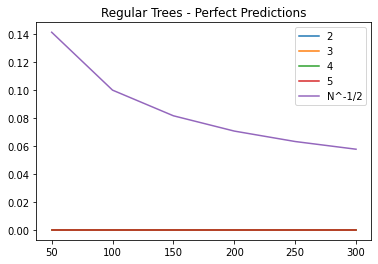

In [20]:
import matplotlib.pyplot as plt

for d in degrees:
    plt.plot(sizes, [l[2] / samples for l in perfect_predictions if l[0] == d], label=d)
    
plt.plot(sizes, list(map(lambda x: x**-(1/2), sizes)), label="N^-1/2")
plt.legend()
plt.title("Regular Trees - Perfect Predictions")

Text(0.5, 0, 'Degree of Regular Tree')

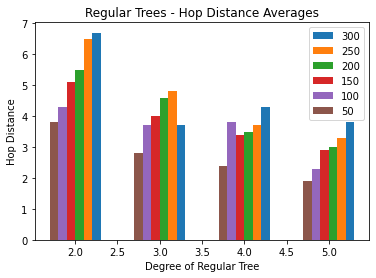

In [35]:
import matplotlib.pyplot as plt
import numpy as np

for i, s in enumerate(reversed(sizes)):
    plt.bar(np.array(degrees) - 0.1 * i + 0.25, [sum(l[2])/len(l[2]) for l in results if l[1] == s], label=s, width=.1)
    
plt.legend()
plt.title("Regular Trees - Hop Distance Averages")
plt.ylabel("Hop Distance")
plt.xlabel("Degree of Regular Tree")

These results are not good, far worse than the paper states. I therefor assume, that they do not simulate SI on the trees (also hinted by that they explicitly state the simulation in 4.2, but not in 4.1). However, an interesing insight: A higher degree of a node in tree graphs seems to improve prediction performance.

## Geometric Graphs
We do not know what geometric trees are, we therefor create geometric graphs and simulate on them

In [70]:
results = []

with tqdm(total=len(sizes) * 10) as bar:
    for size in sizes:
        _results = []
        for _ in range(10):
            g = nx.random_geometric_graph(1000, 0.1)
            read_only = g.copy(as_view=True)

            infected_g, c = si(g, *si_config, max_infected_nodes=size)
            adj_list = raw.networkx_graph_to_adj_list(infected_g)

            predicted_c = raw.get_center_prediction(adj_list)

            hop_distance = nx.shortest_path_length(read_only, c[0], predicted_c[0])
            _results.append(hop_distance)
            bar.update(1)
        results.append((size, _results))

100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:12<00:00,  4.66it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Infected Nodes')

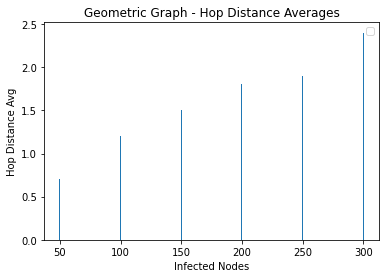

In [71]:
import matplotlib.pyplot as plt
import numpy as np



plt.bar(sizes, list(map(lambda x: sum(x[1]) / len(x[1]), results)))
    
plt.legend()
plt.title("Geometric Graph - Hop Distance Averages")
plt.ylabel("Hop Distance Avg")
plt.xlabel("Infected Nodes")

More infected nodes make it harder to predict the center.

## General Networks

In [72]:
# General Networks
from tqdm import tqdm

from rumor_centrality.graph_generator import scale_free, small_world
from rumor_centrality.graph_simulations import si
import rumor_centrality.jordan_center_alternative as jo

node_count = 5000
sample_size = 100

rumor_cent = []
dist_cent = []

for _ in tqdm(range(sample_size)):
    g = scale_free(node_count)
    inf_g, c = si(g, 100, .1, 1)
    adj_list = raw.networkx_graph_to_adj_list(inf_g)
    rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)
    dc_prediction = jo.centers_by_distance_centrality(inf_g)
    rumor_cent.append(nx.shortest_path_length(g, c[0], rc_prediction[0]))
    dist_cent.append(nx.shortest_path_length(g, c[0], dc_prediction[0]))

100%|████████████████████████████████████████████████████████████████████| 100/100 [02:45<00:00,  1.65s/it]


(array([17.,  0., 45.,  0.,  0., 31.,  0.,  5.,  0.,  2.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

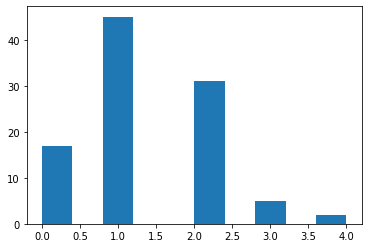

In [73]:
import matplotlib.pyplot as plt

plt.hist(rumor_cent)

(array([16.,  0., 47.,  0.,  0., 28.,  0.,  8.,  0.,  1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

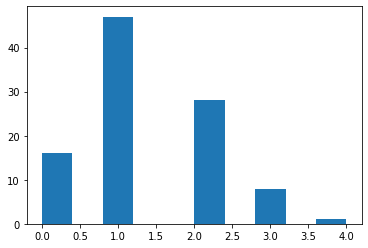

In [74]:
plt.hist(dist_cent)

## Real World Networks

In [ ]:
from rumor_centrality.graph_generator import internet, us_power_grid
import networkx as nx

hops = []
for _ in tqdm(range(100)):
    g, c = si(internet(), 10, 0.1, 1)
    print(f"nodes: {len(g.nodes)}")
    adj_list = raw.networkx_graph_to_adj_list(g)
    rc_prediction = raw.get_center_prediction(adj_list, use_fact=False)
    hops.append(nx.shortest_path_length(g, c[0], rc_prediction[0]))

  1%|▋                                                                     | 1/100 [00:00<00:35,  2.80it/s]

nodes: 346
nodes: 2529


In [ ]:
import matplotlib.pyplot as plt

plt.hist(hops)